In [ ]:
! pip install requests

In [ ]:
import pandas as pd
import requests
import xml.etree.ElementTree as ET
import xml.etree.ElementTree as ET

In [173]:
data = pd.read_csv("Stars_Names.csv")
data.head()

,Name,Constellation,Bayern Designation,Designation,Approval Date
0,Acamar,Eridanus,θ1 Eridani A,HR 897,2016-07-20
1,Achernar,Eridanus,α Eridani A,HR 472,2016-06-30
2,Achird,Cassiopeia,η Cassiopeiae A,HR 219,2017-09-05
3,Acrab,Scorpius,β1 Scorpii Aa,HR 5984,2016-08-21
4,Acrux,Crux,α Crucis Aa,HR 4730,2016-07-20


### Extracting Information from API

In [174]:
def data_extraction(star_name):
    xml_data = get_star_coordinates(star_name)
    root = ET.fromstring(xml_data)

    # Extract relevant information from the XML
    star_name = root.find(".//name").text if root.find(".//name") is not None else None
    if star_name is None:
        print(f"Missing star name for {star_name}")
    
    right_ascension = root.find(".//jradeg").text if root.find(".//jradeg") is not None else None
    declination = root.find(".//jdedeg").text if root.find(".//jdedeg") is not None else None
    star_type = root.find(".//spType").text if root.find(".//spType") is not None else None

    position = root.find(".//jpos").text if root.find(".//jpos") is not None else None
    radial_velocity = root.find(".//Vel/v").text if root.find(".//Vel/v") is not None else None
    parallax = root.find(".//plx/v").text if root.find(".//plx/v") is not None else None
    proper_motion = root.find(".//pm/v").text if root.find(".//pm/v") is not None else None

    return (star_name, right_ascension, declination, star_type, position, radial_velocity, parallax, proper_motion)


In [175]:
# Define the column structure
columns = ['Star Name', 'Right Ascension', 'Declination', 'Star Type', 
           'Position', 'Radial Velocity', 'Parallax', 'Proper Motion']

# Initialize an empty DataFrame
star_df = pd.DataFrame(columns=columns)

# Define a function to append a new star row
def append_star_row(df, star_data):
    new_row = pd.DataFrame([{
        'Star Name': star_data[0], 
        'Right Ascension': star_data[1], 
        'Declination': star_data[2], 
        'Star Type': star_data[3], 
        'Position': star_data[4], 
        'Radial Velocity': star_data[5], 
        'Parallax': star_data[6], 
        'Proper Motion': star_data[7]
    }])
    
    df = pd.concat([df, new_row], ignore_index=True)
    return df


In [176]:
for star in data["Name"]:
    star_data = data_extraction(star)
    star_df = append_star_row(star_df, star_data)

In [177]:
star_df.head()

,Star Name,Right Ascension,Declination,Star Type,Position,Radial Velocity,Parallax,Proper Motion
0,Acamar,44.56531355667,-40.30468122722,A2V,02:58:15.67 -40:18:16.8,11.90,20.23,57.28
1,Achernar,24.428522833,-57.236752806,B6Vpe,01:37:42.84 -57:14:12.3,8.470,23.39,95.03
2,Achird,12.2762274762175,57.81517728880999,F9V,00:49:06.29 +57:48:54.6,8.404,168.8322,1211.258
3,Acrab,241.359292,-19.805389,B1V+B2V,16:05:26.23 -19:48:19.4,None,None,None
4,Acrux,186.649563401,-63.099092858,B0.5IV+B1V,12:26:35.89 -63:05:56.7,11.90,10.13,38.79


In [178]:
merged_df = pd.merge(star_df, data[['Name', 'Constellation']], left_on='Star Name', right_on='Name', how='left')
merged_df.drop(columns=['Name'], inplace=True)  

In [179]:
merged_df.head()

,Star Name,Right Ascension,Declination,Star Type,Position,Radial Velocity,Parallax,Proper Motion,Constellation
0,Acamar,44.56531355667,-40.30468122722,A2V,02:58:15.67 -40:18:16.8,11.90,20.23,57.28,Eridanus
1,Achernar,24.428522833,-57.236752806,B6Vpe,01:37:42.84 -57:14:12.3,8.470,23.39,95.03,Eridanus
2,Achird,12.2762274762175,57.81517728880999,F9V,00:49:06.29 +57:48:54.6,8.404,168.8322,1211.258,Cassiopeia
3,Acrab,241.359292,-19.805389,B1V+B2V,16:05:26.23 -19:48:19.4,None,None,None,Scorpius
4,Acrux,186.649563401,-63.099092858,B0.5IV+B1V,12:26:35.89 -63:05:56.7,11.90,10.13,38.79,Crux


In [180]:
# Convert columns to numeric
cols_to_convert = ['Right Ascension', 'Declination', 'Radial Velocity', 'Parallax', 'Proper Motion']
for col in cols_to_convert:
    merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce')


In [ ]:
merged_df.dropna()

In [ ]:
! pip install scikit-learn

In [182]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

features = merged_df[['Right Ascension', 'Declination', "Radial Velocity", 'Parallax', 'Proper Motion']].dropna()
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

kmeans = KMeans(n_clusters=5, random_state=42)
merged_df.loc[features.index, 'Cluster'] = kmeans.fit_predict(scaled_features)


In [183]:
centroids = kmeans.cluster_centers_
print(pd.DataFrame(centroids, columns=['Right Ascension', 'Declination', "Radial Velocity", 'Parallax','Proper Motion']))


   Right Ascension  Declination  Radial Velocity  Parallax  Proper Motion
0        -0.817470    -1.026291         0.500972 -0.247617      -0.186674
1         0.530127    -1.528297        -0.971761  7.951454       7.077570
2         0.756578     0.899625        -0.458529 -0.060100      -0.068369
3        -0.977860     0.539108         0.230602 -0.021937      -0.020645
4         0.901254    -0.838783        -0.082344 -0.129693      -0.120851


In [184]:
counts = pd.Series(kmeans.labels_).value_counts()
print(counts)

3    100
2     87
4     83
0     55
1      4
Name: count, dtype: int64


In [185]:
cluster0 = merged_df[merged_df['Cluster'] == 0]
cluster1 = merged_df[merged_df['Cluster'] == 1]
cluster2 = merged_df[merged_df['Cluster'] == 2]
cluster3 = merged_df[merged_df['Cluster'] == 3]
cluster4 = merged_df[merged_df['Cluster'] == 4]

In [196]:
frequency = data[data['Constellation'] == "Centaurus"]
frequency

,Name,Constellation,Bayern Designation,Designation,Approval Date
149,Hadar,Centaurus,β Centauri Aa,HR 5267,2016-08-21
196,Menkent,Centaurus,θ Centauri,HR 5288,2016-08-21
247,Proxima Centauri,Centaurus,α Centauri C,GJ 551,2016-08-21
256,Rigil Kentaurus,Centaurus,α Centauri A,HR 5459,2016-11-06
308,Toliman,Centaurus,α Centauri B,HR 5460,2018-08-10


#### - Cluster 1

In [197]:
cluster1

,Star Name,Right Ascension,Declination,Star Type,Position,Radial Velocity,Parallax,Proper Motion,Constellation,Cluster
87,Barnard's Star,269.452077,4.693365,M4V,17:57:48.49 +04:41:36.1,-110.110000,546.9759,10393.349,NaN,1.0
247,Proxima Centauri,217.428942,-62.679490,M5.5Ve,14:29:42.94 -62:40:46.1,-20.578199,768.0665,3859.228,Centaurus,1.0
256,Rigil Kentaurus,219.902058,-60.833993,G2V,14:39:36.49 -60:50:02.3,-15.252000,742.1200,3709.620,Centaurus,1.0
308,Toliman,219.896096,-60.837528,K1V,14:39:35.06 -60:50:15.0,-22.586000,742.1200,3702.510,Centaurus,1.0


The Cluster 1 Shows:

- High proper motion, indicating proximity.

- Very high parallax values (742–768 mas), also reflecting closeness.

- Negative radial velocity, indicating they are moving toward us.

#### - Cluster 3

In [200]:
cluster3

,Star Name,Right Ascension,Declination,Star Type,Position,Radial Velocity,Parallax,Proper Motion,Constellation,Cluster
2,Achird,12.276227,57.815177,F9V,00:49:06.29 +57:48:54.6,8.4040,168.8322,1211.258,Cassiopeia,3.0
5,Acubens,134.621684,11.857680,kA7VmF0/2III/IVSr,08:58:29.20 +11:51:27.6,-14.7900,18.3304,52.442,Cancer,3.0
6,Adhafera,154.172563,23.417317,F0IIIa,10:16:41.41 +23:25:02.3,-12.3200,14.0377,22.717,Leo,3.0
8,Adhil,20.585084,45.528777,K0-IIIb,01:22:20.42 +45:31:43.5,-12.3534,14.6042,32.941,Andromeda,3.0
17,Alcyone,56.871152,24.105136,B7III,03:47:29.07 +24:06:18.4,5.4000,8.0900,47.760,Taurus,3.0
...,...,...,...,...,...,...,...,...,...,...
305,Tianguan,84.411189,21.142544,B1IVe_shell,05:37:38.68 +21:08:33.1,20.0000,7.3300,20.150,Taurus,3.0
307,Titawin,24.199340,41.405459,F9V,01:36:47.84 +41:24:19.6,-28.6620,74.1940,418.724,Andromeda,3.0
310,Torcular,26.348438,9.157751,G8III,01:45:23.62 +09:09:27.9,12.1600,12.5296,89.218,Pisces,3.0
318,Wasat,110.030727,21.982304,F2VkF0mF0,07:20:07.37 +21:58:56.2,4.1000,53.7692,31.379,Gemini,3.0


### 🌟 1. Diversity of Spectral Types
This cluster contains a wide range of spectral types:

O & B stars: Very hot, massive, and young stars (e.g., O8IIIf, O9.5IINwk, B1IV, B8V, B6IIIe, B9.5V)

A & F stars: Hot to moderately hot stars, some chemically peculiar (A0VpSi, F5Ib, F2III)

G, K, M stars: Cooler, more evolved stars (giants/supergiants), e.g., K4.5III, M1.5IIIa, G9.5IIIabCN0.5

🟡 Conclusion: The cluster spans early-type stars (O/B) and late-type giants (G/K/M) → this suggests a mix of young and old stellar populations, possibly due to overlapping spatial motion or proximity.





### 🌌 2. Many Evolved Stars (Giants & Supergiants)
Star types like K0-IIIb, K3-IIICN0.5, G5III, M3IIIab, and F5Ib indicate many stars are:

Giants or supergiants, i.e., in post-main-sequence stages.

Stars like M1-M2Ia-Iab, G8Ib, and K3-Ib-IIa suggest very luminous, massive, and late-stage stars.

🟠 Conclusion: Cluster 3 likely contains a lot of evolved stars, indicating that it may be closer to us (since they’re bright and we can detect them easily), or part of a group with similar evolutionary timelines.


### Principal Component Analysis

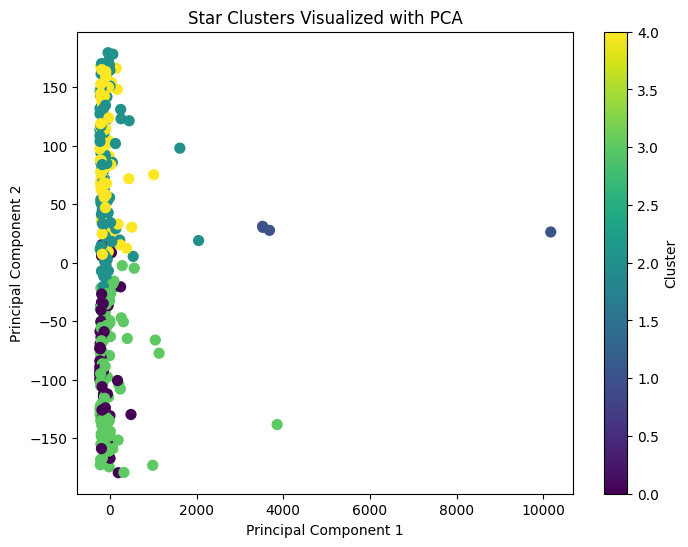

In [201]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Assuming 'features' is your DataFrame with the relevant features
pca = PCA(n_components=2)
components = pca.fit_transform(features)

cluster_labels = kmeans.labels_
plt.figure(figsize=(8,6))
plt.scatter(components[:, 0], components[:, 1], c=cluster_labels, cmap='viridis', s=50)
plt.title('Star Clusters Visualized with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()
